In [1]:
import torch
from torch import nn
from torch.optim import SGD, Adam
from annpy.models.gan import GAN
from annpy.training import GANTrainer
from torchvision import transforms
from torch.utils.data import DataLoader
from pokemon_dataset import PokemonDataset
from torchtrainer.callbacks import ProgbarLogger
from torchtrainer.utils.data import CrossFoldValidation
import matplotlib.pyplot as plt

BATCH_SIZE=30
USE_CUDA=True

## Model ##

In [2]:
class Discriminator(nn.Module):
    """ GAN Model for generate MNIST digits """
    def __init__(self, last_act=None):
        super(Discriminator, self).__init__()

        self._filter = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=2),
                                     nn.BatchNorm2d(32),
                                     nn.LeakyReLU(inplace=True),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(inplace=True),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(inplace=True),
                                     nn.MaxPool2d(2))
                                          # nn.Dropout(0.5))
        self._classifier = nn.Sequential(nn.Linear(7*7*128, 1),
                                         nn.Dropout(0.2)
                                         )

    def forward(self, x):
        x = self._filter(x)
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        x = self._classifier(x)
        return x

    @property
    def input_shape(self):
        return (3, 128, 128)

class Generator(nn.Module):
    """ GAN Model for generate MNIST digits """
    def __init__(self, last_act=None):
        super(Generator, self).__init__()
        self._layers = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=10, stride=5, padding=0),
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(inplace=True),
                                     nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=8, stride=4, padding=1),
                                     nn.BatchNorm2d(256),
                                     nn.LeakyReLU(inplace=True),
                                     nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=6, stride=3, padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(inplace=True),
                                     nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=2, stride=1, padding=0),
                                     nn.Sigmoid(),
                                     # nn.Dropout(0.2),
                                     )


    def forward(self, x):
        x = x.view(-1,64,1, 1)
        #print(self._layers(x).shape)
        return self._layers(x)
    
    @property
    def input_shape(self):
        return (64, )

In [3]:
gen = Generator()
dis = Discriminator()

In [4]:
m = GAN(discriminator=dis, generator=gen)

In [5]:
m.discriminate(m.sample(1))

Variable containing:
1.00000e-04 *
  2.5536
[torch.FloatTensor of size 1x1]

In [6]:
def showsample():
    im = m.sample(1).data[0]
    if USE_CUDA:
        im = im.cpu()
    plt.imshow(im.cpu().numpy().transpose(1, 2, 0))
    plt.colorbar()
    plt.show()

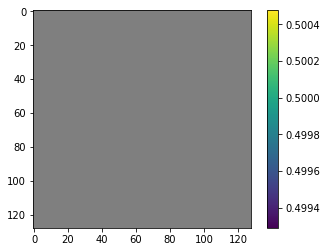

In [7]:
showsample()

## Training ##

In [8]:
g_optimizer = Adam(m.generator.parameters(), lr=1e-3)
d_optimizer = SGD(m.discriminator.parameters(), lr=1e-3)

In [9]:
trainer = GANTrainer(m,
                     d_optimizer,
                     g_optimizer,
                     callbacks=[ProgbarLogger(notebook=True)],
                     logging_frecuency=30,
                     soft_labels_eps=0)

In [10]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

In [11]:
dataset = PokemonDataset(root_dir='data/pokemon', transform=transform)

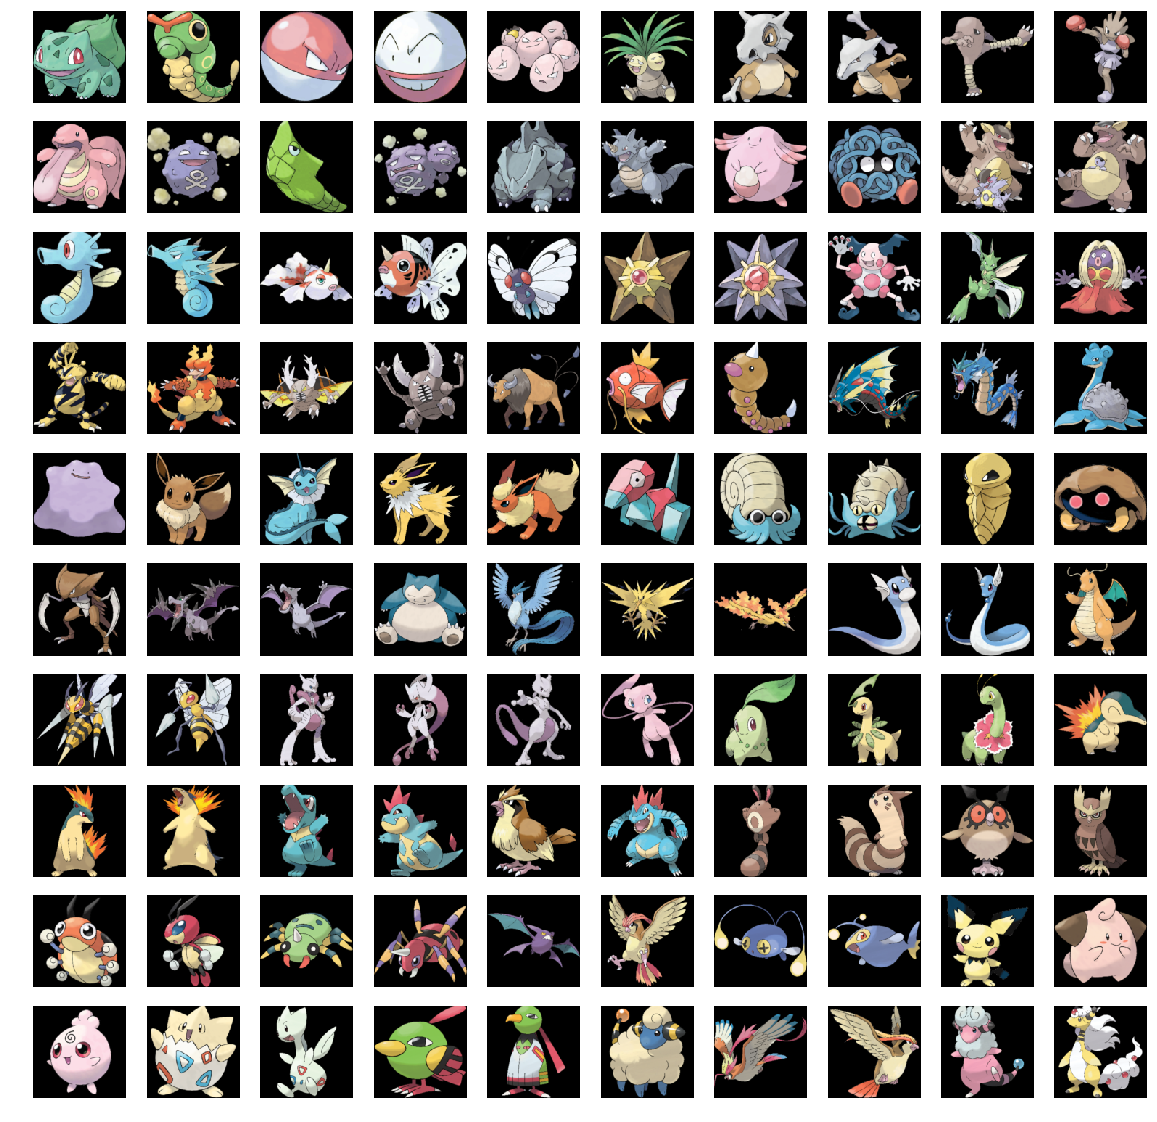

In [12]:
ROWS = 10
COLS = 10
fig = plt.figure(figsize=(20, 20))
#ims = m.sample(ROWS*COLS).data.cpu().numpy().transpose(0,2,3,1)

for i in range(COLS*ROWS):
    sub = fig.add_subplot(COLS, ROWS, i+1)
    sub.imshow(dataset[i].numpy().transpose(1, 2, 0), interpolation='nearest')
    sub.axis('off')
plt.savefig('output.jpg')
plt.show()

In [13]:
train_dl = DataLoader(dataset, batch_size=BATCH_SIZE)

In [14]:
if USE_CUDA:
    trainer.cuda()

In [15]:
trainer.train(train_dl,
              epochs=5)

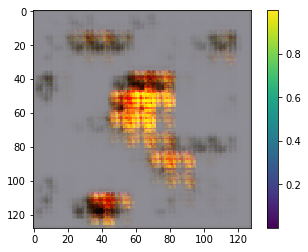

In [16]:
showsample()

In [17]:
trainer.train(train_dl,
              epochs=5)

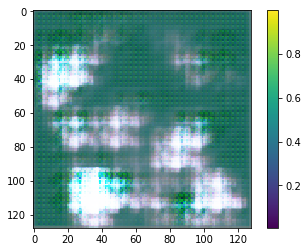

In [18]:
showsample()

In [19]:
trainer.train(train_dl,
              epochs=80)

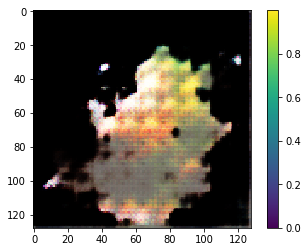

In [20]:
showsample()

## Evaluating ##

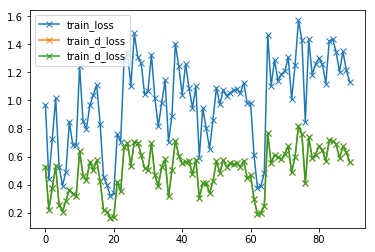

In [21]:
trainer.history.epoch_plot('train_loss')
trainer.history.epoch_plot('train_d_loss')
trainer.history.epoch_plot('train_d_loss')
plt.legend()
plt.show()

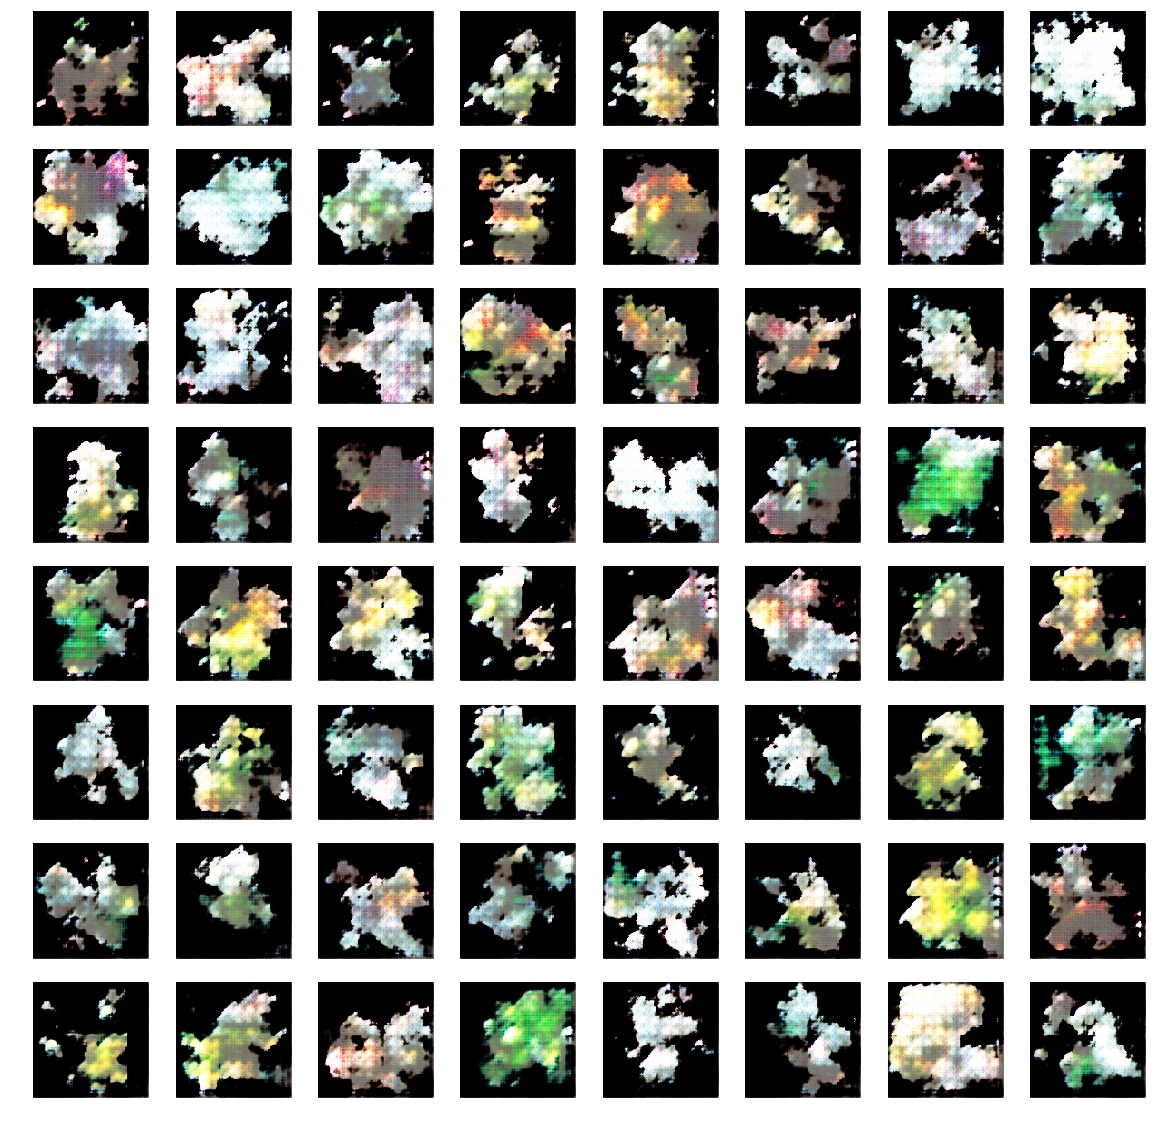

In [22]:
m.eval()
ROWS = 8
COLS = 8
fig = plt.figure(figsize=(20, 20))

for i in range(COLS*ROWS):
    sub = fig.add_subplot(COLS, ROWS, i+1)
    sub.imshow(m.sample(1).data.cpu()[0].numpy().transpose(1,2,0), interpolation='nearest')
    sub.axis('off')
plt.savefig('output/samples/pokemon.1.jpg')
plt.show()